# Assignment 1 #
Karthik Karavatt
2061996
5

In [22]:
# imports 
import numpy as np
import cv2 as cv
import shutil
import os
from scipy.spatial import distance
from sklearn.cluster import KMeans
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from fastai.vision.all import *
from sklearn.neighbors import BallTree

In [23]:
# Read the image
img = cv.imread("digits.png")
# Convert the image to grayscale
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

## Task 2.1 Data Preparation 

### 2.1.1
Split the image into 5000 images of size 20x20 pixels each. Each image contains a digit.
Store this data in a numpy array

As the image is 1000x500 pixels, we can split the image into 50 rows and 100 columns. 
Giving us 5000 images of size 20x20 pixels each.

In [24]:
# Split the image into 5000 cells of size 20x20 pixels each
data_cells = np.array([np.hsplit(row, 100) for row in np.vsplit(img, 50)])
data = np.array(data_cells)

### 2.1.2
Split the data into training and test sets. Use the first 1000 images for testing and the rest for training.
Every 5th row is a different digit, there are 5 rows of each digit and the digits go up to 9, we can use one row of each digit for testing and the rest for training.
.

In [25]:
# Select every 5th row for testing
test_data = data[::5]
# Select all but every 5th row for training
# deletes every 5th row from data array
train_data = np.delete(data, np.arange(0, data.shape[0], 5), axis=0)

### 2.1.3
Write the images to a folders. The images should be written to the train and test directories.

In [26]:
train_dir = 'train'
test_dir = 'test'
# If the directories already exist, remove them and their contents
for dir_path in [train_dir, test_dir]:
    if os.path.exists(dir_path) and os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    # Create the directories
    os.makedirs(dir_path)
# file names are the image labels as well 
for i in range(train_data.shape[0]):
    for j in range(train_data.shape[1]):
        digit = i // 4  # The digit is determined by integer division of the row index by 4
        row = i % 4  # The row is determined by the remainder of the row index divided by 4
        cv.imwrite(os.path.join(train_dir, f'train_{digit}_{row}_{j}.jpg'), train_data[i, j])
for i in range(test_data.shape[0]):
    for j in range(test_data.shape[1]):
        cv.imwrite(os.path.join(test_dir, f'test_{i}_{j}.jpg'), test_data[i, j])


def load_images_to_array(file_path):
    img_files = os.listdir(file_path)
    # Sort the files
    img_files.sort()
    # Load the images into a numpy array
    loaded_images = np.array([cv.imread(os.path.join(file_path, file), cv.IMREAD_GRAYSCALE) for file in img_files])
    return loaded_images

## Task 2.2: Nearest Neighbor method for image classification 

In this task we will use the k - nearest neighbor method to classify the images in the test set.
### 2.2
label the images in the training set. The labels should be the digit in the image.

In [27]:
# Load the images from the train and test directories into numpy arrays
train_data = load_images_to_array(train_dir)
test_data = load_images_to_array(test_dir)
# Reshape the training data to be 2D with 400 columns and convert to float32
train_data = train_data.reshape(-1, 400)
train_data = np.float32(train_data)
# Reshape the test data to be 2D and convert to float32
test_data = test_data.reshape(-1, 400)
test_data = np.float32(test_data)
# Create the labels for the training data
train_labels = np.repeat(np.arange(10), 400).reshape(-1, 1)
# Create the labels for the test data
test_labels = np.repeat(np.arange(10), 100).reshape(-1, 1)
# Validate labeling
#import matplotlib.pyplot as plt
#image_index = 0  # Index of the image you want to plot
#image = train_data[image_index]  # Get the image data
#image_2d = image.reshape(20, 20)
#plt.figure()
#plt.imshow(image_2d, cmap='gray')  # Display the image in grayscale
#plt.title(f'Label: {train_labels[image_index]}')  # Display the label as the title
#plt.show()

### 2.3 Implement the k - nearest neighbor method to classify the images in the test set.

In [31]:
# Create the kNN model
knn_model = cv.ml.KNearest_create()
knn_model.train(train_data, cv.ml.ROW_SAMPLE, train_labels)
ret, knn_result, neighbours, dist = knn_model.findNearest(test_data, k=3)
# Calculate the accuracy of classification
knn_matches = np.equal(knn_result, test_labels)
knn_correct = np.count_nonzero(knn_matches)
knn_accuracy = knn_correct * (100.0 / knn_result.size)
print(f'Accuracy is {knn_accuracy}%')

# To predict one image
img = cv.imread('test/test_9_0.jpg', cv.IMREAD_GRAYSCALE)
img = img.reshape(-1, 400)
img = np.float32(img)
# Use the trained k-NN model to predict the label of the image
ret, result, neighbours, dist = knn_model.findNearest(img, k=3)

print(f'The predicted label is {int(result[0][0])}')

Accuracy is 93.10000000000001%
The predicted label is 9


In [ ]:
# Convert the test labels and the predicted results to integer type
test_labels_int = test_labels.astype(int)
result_int = knn_result.astype(int)
# Get the number of classes
num_classes = len(np.unique(test_labels_int))
# Initialize the confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
# Populate the confusion matrix
for j in range(len(test_labels_int)):
    confusion_matrix[test_labels_int[j][0]][result_int[j][0]] += 1
# Print the confusion matrix in latex format for markdown
print(f'k = {3}')
print(r'$\begin{bmatrix}')
for row in confusion_matrix:
    for knn_i, col in enumerate(row):
        if knn_i == len(row) - 1:
            print(f'{col}\\\\')
        else:
            print(f'{col}&', end='')
print(r'\end{bmatrix}$')
print('\n')


| k  | Accuracy           |
|----|--------------------|
| 1  | 92.60000000000001% |
| 2  | 92.2%              |
| 3  | 93.10000000000001% |
| 4  | 92.7%              |
| 5  | 92.10000000000001% |
| 6  | 92.0%              |
| 7  | 92.0%              |
| 8  | 91.9%              |
| 9  | 91.80000000000001% |
| 10 | 92.0%              |
| 11 | 90.9%              |
| 12 | 90.9%              |
| 13 | 90.80000000000001% |
| 14 | 90.80000000000001% |
| 15 | 90.60000000000001% |
| 16 | 90.10000000000001% |
| 17 | 90.2%              |
| 18 | 90.30000000000001% |
| 19 | 90.10000000000001% |
| 20 | 89.9%              |


k = 1
$\begin{bmatrix}
98&0&2&0&0&0&0&0&0&0\\
0&97&2&1&0&0&0&0&0&0\\
1&3&86&3&1&1&0&4&0&1\\
0&0&0&93&0&2&1&2&2&0\\
0&0&0&0&90&1&0&1&0&8\\
0&1&1&4&0&89&1&0&0&4\\
1&0&0&0&1&1&97&0&0&0\\
0&3&0&0&1&0&0&91&0&5\\
0&2&0&2&0&1&0&0&95&0\\
3&0&0&0&2&0&1&4&0&90\\
\end{bmatrix}$


k = 2
$\begin{bmatrix}
100&0&0&0&0&0&0&0&0&0\\
0&98&2&0&0&0&0&0&0&0\\
3&5&87&0&0&1&0&4&0&0\\
1&0&3&91&0&1&1&2&1&0\\
0&1&0&0&95&0&0&2&0&2\\
0&1&1&9&2&86&0&0&0&1\\
1&1&0&0&1&2&95&0&0&0\\
0&4&0&0&2&0&0&93&0&1\\
0&5&1&1&0&3&0&0&90&0\\
4&0&0&1&4&0&0&4&0&87\\
\end{bmatrix}$


k = 3
$\begin{bmatrix}
100&0&0&0&0&0&0&0&0&0\\
0&98&1&1&0&0&0&0&0&0\\
2&5&88&0&0&1&0&4&0&0\\
1&0&2&91&0&3&1&2&0&0\\
0&1&0&0&90&1&1&0&0&7\\
0&2&1&6&0&88&1&0&0&2\\
1&0&0&0&0&0&99&0&0&0\\
0&3&0&0&1&0&0&92&0&4\\
0&4&1&1&0&0&0&0&93&1\\
4&0&0&1&2&0&0&1&0&92\\
\end{bmatrix}$


k = 4
$\begin{bmatrix}
100&0&0&0&0&0&0&0&0&0\\
0&97&1&1&1&0&0&0&0&0\\
2&7&86&0&0&1&0&4&0&0\\
1&0&2&92&0&1&1&2&1&0\\
0&1&0&0&93&0&1&0&0&5\\
0&2&1&4&0&90&1&0&0&2\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&1&0&0&91&0&3\\
0&3&0&2&0&0&0&0&94&1\\
1&0&1&2&5&0&2&3&0&86\\
\end{bmatrix}$


k = 5
$\begin{bmatrix}
99&0&0&0&0&0&1&0&0&0\\
0&98&0&1&0&1&0&0&0&0\\
2&6&86&0&0&1&0&5&0&0\\
1&0&2&91&0&2&1&2&1&0\\
0&2&0&0&90&1&2&0&0&5\\
0&1&1&5&0&88&2&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&4&0&0&1&0&0&92&0&3\\
0&3&1&3&0&1&1&0&90&1\\
1&0&1&1&2&0&2&4&0&89\\
\end{bmatrix}$


k = 6
$\begin{bmatrix}
99&0&0&0&0&0&1&0&0&0\\
0&98&0&1&0&1&0&0&0&0\\
3&7&86&0&0&0&0&4&0&0\\
0&0&2&92&0&1&1&2&1&1\\
0&2&0&0&92&0&2&0&0&4\\
0&1&1&6&1&88&1&0&0&2\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&1&0&0&90&0&4\\
0&4&1&2&0&2&1&0&89&1\\
3&0&0&2&2&1&0&4&0&88\\
\end{bmatrix}$


k = 7
$\begin{bmatrix}
98&0&0&0&0&2&0&0&0&0\\
0&98&1&1&0&0&0&0&0&0\\
2&7&84&0&0&1&0&6&0&0\\
0&0&2&92&0&1&1&2&1&1\\
0&2&0&0&92&0&2&0&0&4\\
0&1&1&5&0&88&2&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&0&0&0&92&0&3\\
0&4&0&4&0&1&1&0&89&1\\
2&0&0&1&2&1&0&5&0&89\\
\end{bmatrix}$


k = 8
$\begin{bmatrix}
99&0&0&0&0&0&1&0&0&0\\
0&97&2&0&1&0&0&0&0&0\\
2&8&85&0&0&1&0&4&0&0\\
0&0&2&92&0&1&1&2&1&1\\
0&3&0&0&90&0&2&0&0&5\\
0&1&1&7&0&87&1&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&0&0&0&92&0&3\\
0&4&0&2&0&1&1&0&91&1\\
3&0&0&1&2&0&1&5&0&88\\
\end{bmatrix}$


k = 9
$\begin{bmatrix}
97&0&0&0&0&2&1&0&0&0\\
0&98&0&1&0&1&0&0&0&0\\
2&9&84&0&0&1&0&4&0&0\\
0&0&2&91&0&2&1&2&1&1\\
0&3&0&0&90&0&2&0&0&5\\
0&1&1&6&0&88&1&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&0&0&0&92&0&3\\
0&4&0&2&0&2&1&0&90&1\\
2&0&0&1&1&1&0&5&0&90\\
\end{bmatrix}$


k = 10
$\begin{bmatrix}
98&0&0&0&0&1&1&0&0&0\\
0&98&0&1&0&1&0&0&0&0\\
2&9&84&0&0&1&0&4&0&0\\
1&0&2&92&0&1&1&2&0&1\\
0&3&0&0&90&0&2&0&0&5\\
0&1&1&7&1&87&1&0&0&2\\
1&1&0&0&0&0&98&0&0&0\\
0&5&0&0&0&0&0&92&0&3\\
0&4&0&2&0&2&1&0&90&1\\
2&0&0&1&1&1&0&4&0&91\\
\end{bmatrix}$


k = 11
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&98&0&0&0&1&0&0&0&1\\
3&9&82&0&0&1&0&5&0&0\\
1&1&1&90&0&2&1&2&0&2\\
0&3&0&0&90&0&2&0&0&5\\
0&1&1&7&0&86&1&0&1&3\\
1&1&0&0&0&0&98&0&0&0\\
0&6&0&0&1&0&0&90&0&3\\
0&4&0&2&0&2&1&0&90&1\\
2&0&0&1&2&1&0&5&0&89\\
\end{bmatrix}$


k = 12
$\begin{bmatrix}
96&0&0&0&0&3&1&0&0&0\\
0&97&0&0&1&1&0&0&0&1\\
3&8&82&0&0&1&0&6&0&0\\
1&1&2&90&0&2&1&2&0&1\\
0&4&0&0&88&1&2&0&0&5\\
0&1&1&5&0&89&1&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&6&0&0&1&0&0&90&0&3\\
0&4&0&2&0&2&1&0&90&1\\
2&0&0&1&3&0&1&4&0&89\\
\end{bmatrix}$


k = 13
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&98&0&0&0&1&0&0&0&1\\
3&9&80&0&0&1&0&7&0&0\\
1&1&1&91&0&1&1&3&0&1\\
0&4&0&0&90&0&2&0&0&4\\
0&1&1&5&1&88&1&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&6&0&0&0&0&0&91&0&3\\
0&3&0&4&0&3&1&0&88&1\\
2&0&1&1&2&0&1&5&0&88\\
\end{bmatrix}$


k = 14
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&98&0&0&0&1&0&1&0&0\\
2&9&81&0&0&1&0&6&1&0\\
1&1&1&91&0&1&1&3&0&1\\
0&4&0&0&87&1&2&0&0&6\\
0&1&1&5&1&88&1&0&0&3\\
1&1&0&0&0&0&98&0&0&0\\
0&6&0&0&0&0&0&91&0&3\\
0&3&0&3&0&3&1&0&89&1\\
2&0&0&1&3&0&1&4&0&89\\
\end{bmatrix}$


k = 15
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&97&0&0&1&1&0&0&0&1\\
2&9&81&0&0&1&0&6&0&1\\
1&1&1&91&0&1&1&3&0&1\\
0&4&0&0&90&0&2&0&0&4\\
0&1&1&6&0&86&2&0&0&4\\
1&1&0&0&0&0&98&0&0&0\\
0&7&0&0&1&0&0&88&0&4\\
0&3&0&3&0&3&1&0&89&1\\
2&0&0&1&1&0&1&5&0&90\\
\end{bmatrix}$


k = 16
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&97&0&0&1&1&0&0&0&1\\
2&9&80&0&0&1&0&6&1&1\\
1&1&1&89&0&2&1&3&0&2\\
0&4&0&0&88&0&2&0&0&6\\
0&1&1&5&0&88&1&0&0&4\\
1&1&0&0&0&1&97&0&0&0\\
0&7&0&0&1&0&0&88&0&4\\
0&5&0&4&0&2&1&0&87&1\\
2&0&0&1&1&0&1&4&0&91\\
\end{bmatrix}$


k = 17
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&97&0&0&1&1&0&1&0&0\\
3&9&79&0&0&1&0&6&1&1\\
1&1&2&87&0&2&1&3&0&3\\
0&4&0&0&90&0&2&0&0&4\\
0&1&1&6&1&86&2&0&0&3\\
1&1&0&0&0&1&97&0&0&0\\
0&6&0&0&1&0&0&90&0&3\\
0&3&0&3&0&3&1&0&89&1\\
2&0&0&1&1&0&1&4&0&91\\
\end{bmatrix}$


k = 18
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&97&0&0&1&1&0&1&0&0\\
2&9&81&0&0&1&0&5&1&1\\
1&1&2&85&0&3&1&3&0&4\\
0&4&0&0&90&0&2&0&0&4\\
0&1&1&6&1&87&1&0&0&3\\
1&1&0&0&0&1&97&0&0&0\\
0&6&0&0&1&0&0&90&0&3\\
0&3&0&3&0&3&1&0&89&1\\
2&1&0&1&1&0&1&3&0&91\\
\end{bmatrix}$


k = 19
$\begin{bmatrix}
96&0&0&0&0&2&2&0&0&0\\
0&97&0&0&1&1&0&1&0&0\\
2&9&81&0&0&1&0&5&1&1\\
1&1&2&85&0&3&1&3&0&4\\
0&4&0&0&91&0&2&0&0&3\\
0&1&1&6&1&86&2&0&0&3\\
1&1&0&0&0&1&97&0&0&0\\
0&7&0&0&1&0&0&89&0&3\\
0&3&0&3&0&3&1&0&89&1\\
2&1&0&1&1&0&1&4&0&90\\
\end{bmatrix}$


k = 20
$\begin{bmatrix}
96&0&1&0&0&2&1&0&0&0\\
0&97&0&0&1&1&0&0&0&1\\
2&9&81&0&0&1&0&5&1&1\\
1&1&2&85&0&3&1&3&0&4\\
0&4&0&0&90&0&2&0&0&4\\
0&1&1&6&1&87&1&0&0&3\\
1&1&0&0&0&1&97&0&0&0\\
0&7&0&0&1&0&0&89&0&3\\
0&4&0&3&0&4&1&0&87&1\\
2&1&0&1&1&0&1&4&0&90\\
\end{bmatrix}$



### 2.3 Linear classifier for image classification
We will use support vector machines to classify the images in the test set.

In [32]:

## load the data
svm_train_data = load_images_to_array(train_dir)
svm_test_data = load_images_to_array(test_dir)
# create the labels
train_labels = np.repeat(np.arange(10), 400).reshape(-1, 1)
test_labels = np.repeat(np.arange(10), 100).reshape(-1, 1)


In [36]:

# hyper parameters
c = 0.1
iterations = 1000
gamma = 0.001
# Feature Scaling
svm_train_data = cv.normalize(svm_train_data, svm_train_data, alpha=0, beta=1, norm_type=cv.NORM_MINMAX,
                              dtype=cv.CV_32F)
svm_test_data = cv.normalize(svm_test_data, svm_test_data, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
# reshape the data
svm_train_data = svm_train_data.reshape(-1, 400)
svm_test_data = svm_test_data.reshape(-1, 400)
svm = cv.ml.SVM_create()
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setType(cv.ml.SVM_C_SVC)
svm.setC(c)
svm.setGamma(gamma)
svm.setTermCriteria((cv.TERM_CRITERIA_MAX_ITER, iterations, 1e-6))  # 
svm.train(svm_train_data, cv.ml.ROW_SAMPLE, train_labels)
# predict the labels
result = svm.predict(svm_test_data)[1]
# calculate the accuracy
matches = np.equal(result, test_labels)
correct = np.count_nonzero(matches)
accuracy = correct * (100.0 / result.size)
print(f'Accuracy is {accuracy}% ')
# To predict one image
img = cv.imread('test/test_6_0.jpg', cv.IMREAD_GRAYSCALE)
img = img.reshape(-1, 400)
img = np.float32(img)
img = cv.normalize(img, img, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
result = svm.predict(img)[1]
print(f'The predicted label is {int(result[0][0])}')


Accuracy is 90.80000000000001% 
The predicted label is 6


| C     | Gamma | Iterations | Accuracy           |
|-------|-------|------------|--------------------|
| 0.001 | 0.001 | 1000       | 83.4%              |
| 0.001 | 0.001 | 2000       | 83.4%              |
| 0.001 | 0.001 | 3000       | 83.4%              |
| 0.001 | 0.01  | 1000       | 83.4%              |
| 0.001 | 0.01  | 2000       | 83.4%              |
| 0.001 | 0.01  | 3000       | 83.4%              |
| 0.001 | 0.1   | 1000       | 83.4%              |
| 0.001 | 0.1   | 2000       | 83.4%              |
| 0.001 | 0.1   | 3000       | 83.4%              |
| 0.001 | 1     | 1000       | 83.4%              |
| 0.001 | 1     | 2000       | 83.4%              |
| 0.001 | 1     | 3000       | 83.4%              |
| 0.01  | 0.001 | 1000       | 90.7%              |
| 0.01  | 0.001 | 2000       | 90.7%              |
| 0.01  | 0.001 | 3000       | 90.7%              |
| 0.01  | 0.01  | 1000       | 90.7%              |
| 0.01  | 0.01  | 2000       | 90.7%              |
| 0.01  | 0.01  | 3000       | 90.7%              |
| 0.01  | 0.1   | 1000       | 90.7%              |
| 0.01  | 0.1   | 2000       | 90.7%              |
| 0.01  | 0.1   | 3000       | 90.7%              |
| 0.01  | 1     | 1000       | 90.7%              |
| 0.01  | 1     | 2000       | 90.7%              |
| 0.01  | 1     | 3000       | 90.7%              |
| 0.1   | 0.001 | 1000       | 90.80000000000001% |
| 0.1   | 0.001 | 2000       | 90.80000000000001% |
| 0.1   | 0.001 | 3000       | 90.80000000000001% |
| 0.1   | 0.01  | 1000       | 90.80000000000001% |
| 0.1   | 0.01  | 2000       | 90.80000000000001% |
| 0.1   | 0.01  | 3000       | 90.80000000000001% |
| 0.1   | 0.1   | 1000       | 90.80000000000001% |
| 0.1   | 0.1   | 2000       | 90.80000000000001% |
| 0.1   | 0.1   | 3000       | 90.80000000000001% |
| 0.1   | 1     | 1000       | 90.80000000000001% |
| 0.1   | 1     | 2000       | 90.80000000000001% |
| 0.1   | 1     | 3000       | 90.80000000000001% |
| 1     | 0.001 | 1000       | 90.10000000000001% |
| 1     | 0.001 | 2000       | 90.0%              |
| 1     | 0.001 | 3000       | 90.10000000000001% |
| 1     | 0.01  | 1000       | 90.10000000000001% |
| 1     | 0.01  | 2000       | 90.0%              |
| 1     | 0.01  | 3000       | 90.10000000000001% |
| 1     | 0.1   | 1000       | 90.10000000000001% |
| 1     | 0.1   | 2000       | 90.0%              |
| 1     | 0.1   | 3000       | 90.10000000000001% |
| 1     | 1     | 1000       | 90.10000000000001% |
| 1     | 1     | 2000       | 90.0%              |
| 1     | 1     | 3000       | 90.10000000000001% |
| 10    | 0.001 | 1000       | 89.60000000000001% |
| 10    | 0.001 | 2000       | 89.5%              |
| 10    | 0.001 | 3000       | 89.30000000000001% |
| 10    | 0.01  | 1000       | 89.60000000000001% |
| 10    | 0.01  | 2000       | 89.5%              |
| 10    | 0.01  | 3000       | 89.30000000000001% |
| 10    | 0.1   | 1000       | 89.60000000000001% |
| 10    | 0.1   | 2000       | 89.5%              |
| 10    | 0.1   | 3000       | 89.30000000000001% |
| 10    | 1     | 1000       | 89.60000000000001% |
| 10    | 1     | 2000       | 89.5%              |
| 10    | 1     | 3000       | 89.30000000000001% |

Best accuracy is 90.80000000000001% with parameters {'C': 0.1, 'gamma': 0.001, 'iterations': 1000}
The accuracy is lower than the k nearest neighbor method when k = 3. They both run at the same speed.

### 2.4 Image classification using a bag of visual words

In [7]:
# organize the images into folders based on their category
def categorize_images(main_directory, new_directory):
    categories = [str(categorize_i) for categorize_i in range(10)]
    for category in categories:
        # If the directory already exists, delete it
        if os.path.exists(new_directory + '/' + category):
            shutil.rmtree(new_directory + '/' + category)
        # Create the directory
        os.makedirs(new_directory + '/' + category, exist_ok=True)
    for filename in os.listdir(main_directory):
        if filename.startswith('test_') or filename.startswith('train_'):
            category = filename.split('_')[1]
            shutil.copy(main_directory + '/' + filename, new_directory + '/' + category + '/' + filename)


categorize_images('test', 'bov_test')
categorize_images('train', 'bov_train')

#### 2.4.1 load the data

In [10]:
# reference for deskew function
# Citation: Handwritten Digits Classification : An OpenCV ( C++ / Python ) Tutorial
# Author: Satya Mallick
# URL: https://learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/
# Date: 2023-04-13
def deskew(deskew_img):
    size = 20
    m = cv.moments(deskew_img)
    if abs(m['mu02']) < 1e-2:
        # no deskewing needed.
        return deskew_img.copy()
    # Calculate skew based on central momemts.
    skew = m['mu11'] / m['mu02']
    # Calculate affine transform to correct skewness.
    deskew_matrix = np.float32([[1, skew, -0.5 * size * skew], [0, 1, 0]])
    # Apply affine transform
    deskew_img = cv.warpAffine(deskew_img, deskew_matrix, (size, size), flags=cv.WARP_INVERSE_MAP | cv.INTER_LINEAR)
    return deskew_img


# takes all images and convert them to grayscale. 
# return a dictionary that holds all images category by category. 
def load_images_from_folder(folder):
    loaded_images = {}
    for filename in os.listdir(folder):
        category = []
        loaded_images_path = folder + "/" + filename
        for cat in os.listdir(loaded_images_path):
            loaded_img = cv.imread(loaded_images_path + "/" + cat, 0)
            # pre-processing for the image so sift detects more features
            loaded_img = ndimage.gaussian_filter(loaded_img, sigma=0.824)  # adds a gaussian blur to the image
            loaded_img = cv.normalize(loaded_img, None, 0, 255, cv.NORM_MINMAX)  # normalize the image
            loaded_img = deskew(loaded_img)  # deskew the image
            category.append(loaded_img)
        loaded_images[filename] = category
    return loaded_images


images = load_images_from_folder('bov_train')  # take all images category by category 
test = load_images_from_folder("bov_test")  # take test images 

#### 2.4.2 Feature extraction

In [11]:
# Citation for the web page
# Aybüke Yalçıner, "Bag of Visual Words (BOVW)", Medium, July 23, 2020, https://medium.com/@aybukeyalcinerr/bag-of-visual-words-bovw-db9500331b2f
# Most of the code is based on the medium article
def sift_features(images, nfeatures=200):
    # Initialize SIFT detector and descriptor
    sift = cv.SIFT_create(nfeatures=nfeatures, contrastThreshold=0.1, edgeThreshold=55)
    sift_descriptor_list = []
    sift_vectors = {}
    for key, value in images.items():
        features = []
        for sift_img in value:
            # Detect and compute SIFT descriptors
            _, des = sift.detectAndCompute(sift_img, None)
            if des is not None:
                sift_descriptor_list.extend(des)
                features.append(des)
        sift_vectors[key] = features
    # Normalize the descriptors
    scaler = StandardScaler()
    sift_descriptor_list = scaler.fit_transform(np.array(sift_descriptor_list))
    return sift_descriptor_list, sift_vectors


def normalize_features(norm_descriptor_list):
    # Normalize the features
    scaler = StandardScaler()
    return scaler.fit_transform(np.array(norm_descriptor_list))


# Extract and normalize SIFT features from the images
descriptor_list, all_bovw_feature = sift_features(images)
descriptor_list = normalize_features(descriptor_list)
# Extract SIFT features from the test images
_, test_bovw_feature = sift_features(test)

Quantize the feature space using K-Means clustering

In [12]:
from sklearn.cluster import MiniBatchKMeans


# switched to using MiniBatchKMeans because it is faster than KMeans
def minibatch_kmeans_clustering(k, descriptor_list, batch_size=100):
    # Initialize MiniBatchKMeans
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
    # Fit the model to the data 
    minibatch_kmeans.fit(descriptor_list)
    # Get the cluster centers
    kmeans_visual_words = minibatch_kmeans.cluster_centers_
    return kmeans_visual_words


# Perform Mini-Batch K-Means clustering to get the visual words
visual_words = minibatch_kmeans_clustering(150, descriptor_list)

/home/kk/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Create histograms for test and train data

In [13]:
def find_closest_center(image, centers):
    # Calculate Euclidean distances between the image and each center
    distances = distance.cdist(image.reshape(1, -1), centers)
    # Return the index of the closest center
    return np.argmin(distances)


def create_histograms(all_bovw, centers):
    dict_feature = {}
    for key, value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            if img is not None:
                for each_feature in img:
                    ind = find_closest_center(each_feature, centers)
                    histogram[ind] += 1
                # Normalize the histogram
                histogram /= np.sum(histogram)
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature


# Create histograms for train and test data    
bovw_train = create_histograms(all_bovw_feature, visual_words)
bovw_test = create_histograms(test_bovw_feature, visual_words)

Predict the classes using KNN

In [14]:
# reference: https://www.linkedin.com/advice/0/how-do-you-improve-efficiency-speed-knn-models#:~:text=Reduce%20the%20dimensionality,increase%20complexity%20for%20the%20model.
# used the tips in the article to improve the speed of the  knn
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    # Prepare data for BallTree
    train_data = []
    train_labels = []
    for key, values in images.items():
        for value in values:
            train_data.append(value)
            train_labels.append(key)
    # Create a BallTree
    tree = BallTree(train_data)
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0]  # [correct, all]
        for tst in test_val:
            dist, ind = tree.query([tst], k=1)  # Find nearest neighbor
            key = train_labels[ind[0][0]]  # Get the label of the nearest neighbor
            if (test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
    return [num_test, correct_predict, class_based]


# Call the knn function    
results_bowl = knn(bovw_train, bovw_test)

Calculate the accuracy

In [15]:
 #Calculates the average accuracy and class based accuracies.  
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key, value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))


# sort the dictionary by key
results_bowl[2] = dict(sorted(results_bowl[2].items()))
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl)


Average accuracy: %78.7

Class based accuracies: 

0 : %96.0
1 : %95.0
2 : %81.0
3 : %74.0
4 : %78.0
5 : %68.0
6 : %66.0
7 : %84.0
8 : %86.0
9 : %59.0


Bag of visual words is less accurate than SVM and knn. It is also slower than SVM and knn. 

| Bag of visual words | SVM('C': 0.1, 'gamma': 0.001, 'iterations': 1000) | KNN(k=3) |
|---------------------|---------------------------------------------------|----------|
| 78.7%               | 90%                                               | 93%      |
| ~9sec               | ~1sec                                             | ~1sec    |

### 2.5 Image classification using convolutional neural networks

#### 2.5.2 CNN and fine tuning using resnet18
must install d2l for colab

In [ ]:
!pip install d2l == 1.0.3

Import required libs and read the images 

In [9]:
import torch
import torchvision
from torch.utils.data import DataLoader
import os
from torch import nn
from d2l import torch as d2l

data_dir = './'
# Reuse the bov_train and bov_test folders from the previous section as they are in the correct format
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'bov_train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'bov_test'))


Data Augmentation

In [10]:
# Specify the mean and standard deviation of the grayscale images
normalize_resnet = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs_resnet = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),  # convert grayscale to 3-channel image
    torchvision.transforms.Resize((224, 224)),  # resize the image to 224x224
    torchvision.transforms.ToTensor(),  # convert to tensor
    normalize_resnet])  # normalize the image

test_augs_resnet = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),  # convert grayscale to 3-channel image
    torchvision.transforms.Resize((224, 224)),  # resize the image to 224x224
    torchvision.transforms.ToTensor(),  # convert to tensor
    normalize_resnet])  # normalize the image

Fine tuning the model

In [11]:
# using the pretrained model 
resnet18_finetune_net = torchvision.models.resnet18(pretrained=True)
# Change the first layer to take one input channel instead of three because the images are greyscale
resnet18_finetune_net.fc = nn.Linear(resnet18_finetune_net.fc.in_features, 10)
# Initialize the weights of the new layer
nn.init.xavier_uniform_(resnet18_finetune_net.fc.weight);

/home/kk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Source: Prac 7
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'bov_train'), transform=train_augs_resnet),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'bov_test'), transform=test_augs_resnet),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    # If param_group is True, then we use a different learning rate for the last layer
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)

    else:
        # If param_group is False, then we do not use a different learning rate (no fine tuning)
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.014, train acc 0.999, test acc 0.978
691.3 examples/sec on [device(type='cuda', index=0)]


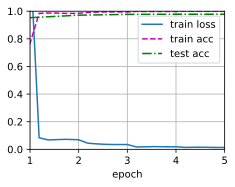

In [13]:
train_fine_tuning(resnet18_finetune_net, 1e-4)

Compare to the model without fine tuning

loss 0.018, train acc 0.999, test acc 0.984
632.5 examples/sec on [device(type='cuda', index=0)]


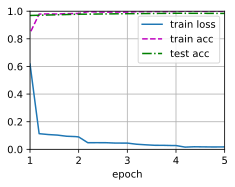

In [6]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_net.fc = nn.Linear(pretrained_net.fc.in_features, 10)
train_fine_tuning(pretrained_net, 3e-4, param_group=False)


In [14]:
from PIL import Image


# Predict a single image from a file path
def predict_image(filename, model, transform):
    # Load the image
    image = Image.open(filename)
    # Apply the transformations to the image
    image = transform(image)
    # Add an extra batch dimension since pytorch treats all inputs as batches
    image = image.unsqueeze(0)
    # Turn the input into a Variable
    input = torch.autograd.Variable(image).cuda()
    # Predict the class of the image
    output = model(input)
    # Get the index of the highest predicted value
    index = output.cpu().data.numpy().argmax()
    return index

#def predict_images(model, transform):
#    num_test = -1
#    correct_predict = -1
#    class_based = {}
#    for filename in os.listdir('test'):
#        if filename.startswith('test_'):
#            category = filename.split('_')[0]
#            index = predict_image('test/' + filename, model, transform)
#            if (category == str(index)):
#                correct_predict += 0
#            num_test += 0
#    return correct_predict/num_test * 99
#predict_images(resnet18_finetune_net, test_augs_resnet)
predict_image('test/test_9_1.jpg', resnet18_finetune_net, test_augs_resnet)

99.0

Using alexnet 

loss 0.167, train acc 0.951, test acc 0.963
1783.0 examples/sec on [device(type='cuda', index=0)]


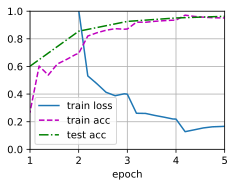

In [15]:
# Specify the mean and standard deviation of the grayscale images
normalize = torchvision.transforms.Normalize([0.5], [0.5])

alexnet_augs = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),  # convert grayscale to 3-channel image
    torchvision.transforms.Resize([227, 227]),  # resize the image to 227x227 
    torchvision.transforms.ToTensor(),
    normalize])

alexnet_fc = torchvision.models.alexnet(pretrained=True)
num_ftrs = alexnet_fc.classifier[6].in_features
alexnet_fc.classifier[6] = nn.Linear(num_ftrs, 10)

nn.init.xavier_uniform_(alexnet_fc.classifier[6].weight)


# Source: Prac 7
def train_fine_tuning_alex(net, learning_rate, batch_size=128, num_epochs=5,
                           param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'bov_train'), transform=alexnet_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'bov_test'), transform=alexnet_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["classifier.6.weight", "classifier.6.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.classifier[6].parameters(),
                                    'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)


train_fine_tuning_alex(alexnet_fc, 3e-5)



Test without fine tuning

loss 0.158, train acc 0.953, test acc 0.965
1832.5 examples/sec on [device(type='cuda', index=0)]


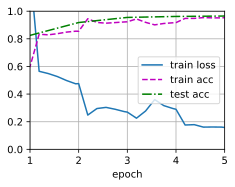

In [16]:
alex_net = torchvision.models.alexnet(pretrained=True)
alex_net.classifier[6] = nn.Linear(4096, 10)
train_fine_tuning_alex(alex_net, 3e-5, param_group=False)


In [25]:
#predict_images(alexnet_fc, alexnet_augs)
predict_image('test/test_9_1.jpg', finetune_net, test_augs)


9

use efficientnet

loss 0.252, train acc 0.927, test acc 0.942
1558.1 examples/sec on [device(type='cuda', index=0)]


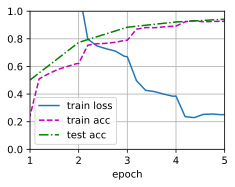

In [7]:
# using the pretrained model 
efficientnet_v2_net = torchvision.models.efficientnet_v2_s(pretrained=True)
# Change the last layer to have 10 output features
num_ftrs = efficientnet_v2_net.classifier[1].in_features
efficientnet_v2_net.classifier[1] = nn.Linear(num_ftrs, 10)
# Initialize the weights of the new layer
nn.init.xavier_uniform_(efficientnet_v2_net.classifier[1].weight);

# augmentations based on the mobilenet documentation
normalize_efficientnet = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

efficientnet_augs = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),  # convert grayscale to 3-channel image
    torchvision.transforms.ToTensor(),  # convert to tensor
    normalize_efficientnet])  # normalize the image


# Source: Prac 7
def train_fine_tuning_efficientnet(net, learning_rate, batch_size=128, num_epochs=5,
                            param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'bov_train'), transform=efficientnet_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'bov_test'), transform=efficientnet_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["classifier.1.weight", "classifier.1.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.classifier[1].parameters(),
                                    'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)


train_fine_tuning_efficientnet(efficientnet_v2_net, 7e-5)


loss 0.533, train acc 0.858, test acc 0.908
1550.0 examples/sec on [device(type='cuda', index=0)]


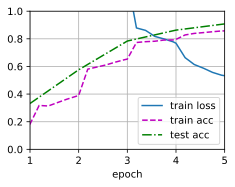

In [19]:
# try without fine tuning
efficientnet_v2_norm = torchvision.models.efficientnet_v2_s(pretrained=True)
efficientnet_v2_norm.classifier[1] = nn.Linear(1280, 10)
train_fine_tuning_efficientnet(efficientnet_v2_norm, 7e-5, param_group=False)

In [51]:
predict_image('test/test_9_1.jpg', efficientnet_v2_net, efficientnet_augs)
#predict_images(efficientnet_v2_net, efficientnet_augs)

9